## Sentence Transformation and Embeddings

### Initialization

#### Acknowledgements

- https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2
- https://www.kaggle.com/datasets/mauricerupp/englishspeaking-politicians (v6 Dataset)
- https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/

#### Packages

In [1]:
import sentence_transformers as pkg_sentence_transformers
import scipy.spatial.distance as pkg_distance
import pandas as pkg_pandas
import sklearn.model_selection as pkg_model_selection
import sklearn.manifold as pkg_manifold
import matplotlib.pyplot as pkg_plot
import seaborn as pkg_seaborn


#### Common

In [2]:
model_path = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
model = pkg_sentence_transformers.SentenceTransformer(model_path)

### Sample: Find Cosine Similiarity

In [3]:
# Reference Sentence
ref_sentence = "That is a happy person"

# Sentences we want compare with
cmp_sentences = [
    "Sunny days make people happy",
    "Rainy days make people happy"
    "Relationships enhance happiness",
    "There is no happy person in the world. Happiness is misnomer",
    "Mind free from tensions make a person happy",
    "People on vacation at beach side over bright and sunny days",
    "People kind at heart and wearing smile always",
    "People having fun, laughing out loud, elevating the mood"
]

ref_embeddings = model.encode(sentences=[ref_sentence])
print("Embedding/Vector Shape = {}".format(ref_embeddings[0].shape))

cmp_embeddings = model.encode(cmp_sentences)

print ("Reference Sentence: {}".format(ref_sentence))
for i in range(len(cmp_embeddings)):
    similiarity = 1 - pkg_distance.cosine(ref_embeddings[0], cmp_embeddings[i])
    print("Cosine Similiarity: {} for sentence = {}".format(similiarity, cmp_sentences[i]))

Embedding/Vector Shape = (768,)
Reference Sentence: That is a happy person
Cosine Similiarity: 0.6686985492706299 for sentence = Sunny days make people happy
Cosine Similiarity: 0.5185865163803101 for sentence = Rainy days make people happyRelationships enhance happiness
Cosine Similiarity: 0.48634278774261475 for sentence = There is no happy person in the world. Happiness is misnomer
Cosine Similiarity: 0.5353088974952698 for sentence = Mind free from tensions make a person happy
Cosine Similiarity: 0.23558664321899414 for sentence = People on vacation at beach side over bright and sunny days
Cosine Similiarity: 0.5658841729164124 for sentence = People kind at heart and wearing smile always
Cosine Similiarity: 0.553466796875 for sentence = People having fun, laughing out loud, elevating the mood


### Play: Find Similar Sentences

#### Load Data

In [4]:
# Configuration Options

# This dataset contains 9567 data points, sample size of 5% means roughly 475 data points
sample_size = 5

# Maximum allowed cosine distance (or Minimum Similarity) %age
max_cosine_distance = 40

In [5]:
baseline_df = pkg_pandas.read_csv("../data/kaggle/datasets/english-speaking-politicians-v6_0.csv.gz", compression='gzip', on_bad_lines='skip')
baseline_df.head()

,Author,Country,Date,Speech,Title,URL
0,Justin Trudeau,Canada,2020-10-20,"Good morning, everyone.\nI’m happy to be here ...",Prime Minister’s remarks on Small Business Wee...,https://pm.gc.ca/en/news/speeches/2020/10/20/p...
1,Justin Trudeau,Canada,2020-10-16,Hello. Good morning everyone.\nI’m pleased to ...,Prime Minister’s remarks on the measures taken...,https://pm.gc.ca/en/news/speeches/2020/10/16/p...
2,Justin Trudeau,Canada,2020-10-13,Hello everyone.\nIt’s good to be here this mor...,Prime Minister’s remarks on COVID-19 testing a...,https://pm.gc.ca/en/news/speeches/2020/10/13/p...
3,Justin Trudeau,Canada,2020-10-09,Hello everyone.\nI’m happy to be joined today ...,Prime Minister’s remarks on support for Canadi...,https://pm.gc.ca/en/news/speeches/2020/10/09/p...
4,Justin Trudeau,Canada,2020-10-08,"Hello everyone.\nThank you, Minister Bains. It...",Prime Minister’s remarks on a new commitment t...,https://pm.gc.ca/en/news/speeches/2020/10/08/p...


In [6]:
baseline_df["Author_Date"] = baseline_df["Author"] + "/" + baseline_df["Date"]
baseline_df.head()

,Author,Country,Date,Speech,Title,URL,Author_Date
0,Justin Trudeau,Canada,2020-10-20,"Good morning, everyone.\nI’m happy to be here ...",Prime Minister’s remarks on Small Business Wee...,https://pm.gc.ca/en/news/speeches/2020/10/20/p...,Justin Trudeau/2020-10-20
1,Justin Trudeau,Canada,2020-10-16,Hello. Good morning everyone.\nI’m pleased to ...,Prime Minister’s remarks on the measures taken...,https://pm.gc.ca/en/news/speeches/2020/10/16/p...,Justin Trudeau/2020-10-16
2,Justin Trudeau,Canada,2020-10-13,Hello everyone.\nIt’s good to be here this mor...,Prime Minister’s remarks on COVID-19 testing a...,https://pm.gc.ca/en/news/speeches/2020/10/13/p...,Justin Trudeau/2020-10-13
3,Justin Trudeau,Canada,2020-10-09,Hello everyone.\nI’m happy to be joined today ...,Prime Minister’s remarks on support for Canadi...,https://pm.gc.ca/en/news/speeches/2020/10/09/p...,Justin Trudeau/2020-10-09
4,Justin Trudeau,Canada,2020-10-08,"Hello everyone.\nThank you, Minister Bains. It...",Prime Minister’s remarks on a new commitment t...,https://pm.gc.ca/en/news/speeches/2020/10/08/p...,Justin Trudeau/2020-10-08


In [7]:
baseline_inputs = baseline_df

# Use Train-Test Splitter to randomly pick the required sample size
train_inputs, test_inputs = pkg_model_selection.train_test_split(baseline_inputs, train_size=sample_size/100)

print("=== Baseline Split - Train and Test ===")
print("Lengths: Baseline = {}, Train = {}, Test = {}".format(len(baseline_inputs), len(train_inputs), len(test_inputs)))

=== Baseline Split - Train and Test ===
Lengths: Baseline = 9567, Train = 478, Test = 9089


In [8]:
# Persist the train samples as these are the ones we refer to using an index
train_inputs.to_csv("../.outputs/persisted/st_mpnet_basev2_sample_sentences.csv", index=False)

#### Process

In [9]:
# Calculate Sentence Embeddings
# (Assume order is preserved)
train_embeddings = model.encode(train_inputs.Speech.array)
train_embeddings.shape

(478, 768)

In [10]:
# Plot the embeddings/vectors

# Reduce the high-dimensional vectors (768) to low-dimensional vectors (2) using t-SNE
tsne = pkg_manifold.TSNE(2)
tsne_result = tsne.fit_transform(train_embeddings)
tsne_result.shape

/home/raooruga/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/raooruga/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(478, 2)

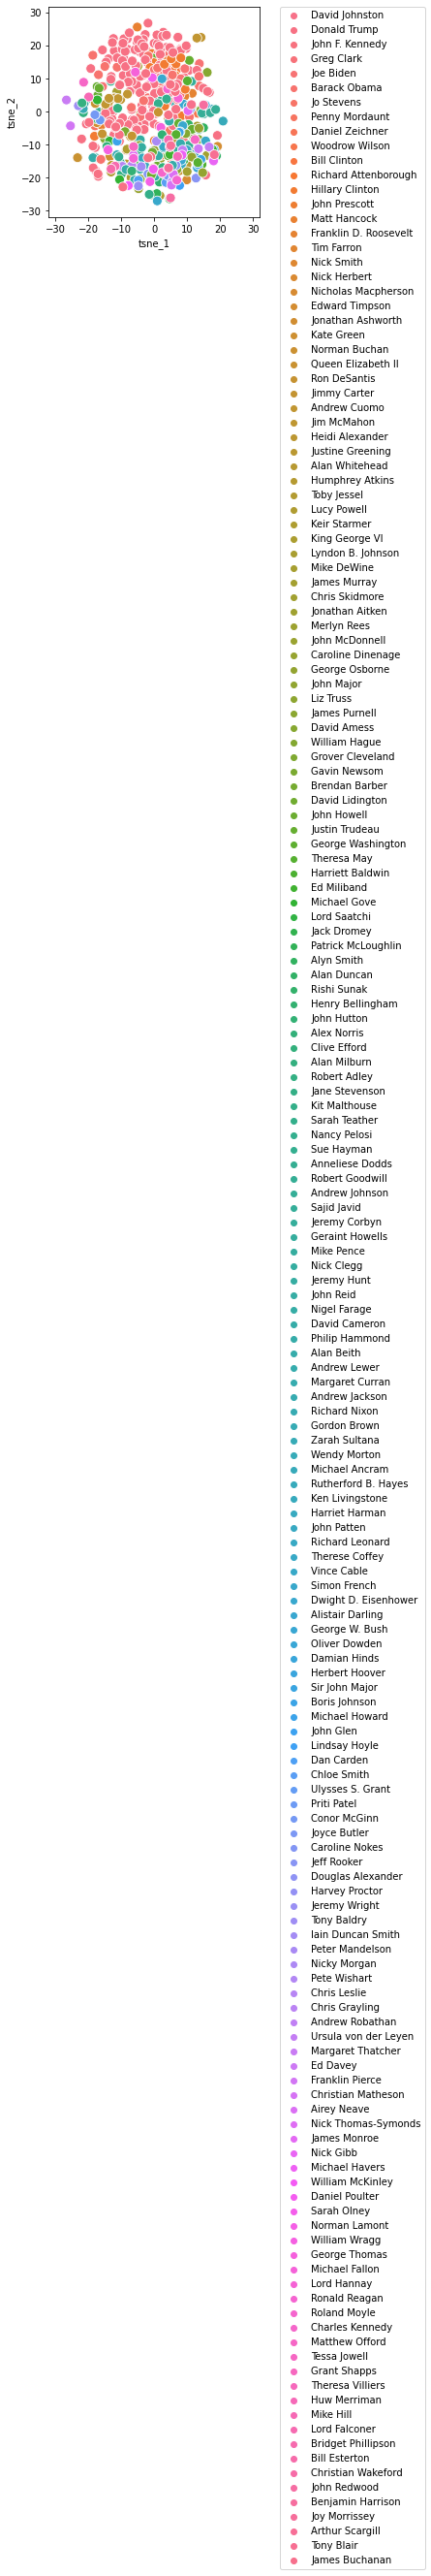

In [11]:
# Plot the result of our TSNE with the label color coded
tsne_result_df = pkg_pandas.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': train_inputs["Author"]})
fig, ax = pkg_plot.subplots(1)
pkg_seaborn.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=100)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.0)

In [12]:
# Calculate Distances/Similarities
similarites_df = pkg_pandas.DataFrame(columns=["i", "j", "cosine_distance", "euclidean_distance"])

for i in range(len(train_embeddings)):
    for j in range(len(train_embeddings)-i-1):
        # Do not compare various speeches of same author (bias removal?) 
        if (train_inputs.iloc[i].Author != train_inputs.iloc[j].Author):
            cosine_distance = pkg_distance.cosine(train_embeddings[i], train_embeddings[i+j+1])
            euclidean_distance = pkg_distance.euclidean(train_embeddings[i], train_embeddings[i+j+1])
            similarites_df.loc[len(similarites_df)] = [i, j, cosine_distance, euclidean_distance]

similarites_df.head()

,i,j,cosine_distance,euclidean_distance
0,0.0,1.0,0.830579,3.395306
1,0.0,2.0,0.642756,3.180664
2,0.0,3.0,0.623622,3.055442
3,0.0,4.0,0.771268,3.455102
4,0.0,5.0,0.706696,3.246517


In [13]:
# Filter rows that have less than maximum allowed cosine distance
similarites_df = similarites_df[(similarites_df["cosine_distance"] < (max_cosine_distance/100))]
similarites_df.head()

,i,j,cosine_distance,euclidean_distance
324,0.0,325.0,0.336952,2.203692
452,0.0,453.0,0.382182,2.296887
722,1.0,376.0,0.374947,2.312223
751,1.0,415.0,0.355516,2.294468
789,2.0,4.0,0.371674,2.374053


In [14]:
# Sort using similarity
similarites_df.sort_values(by=["cosine_distance", "euclidean_distance"], ascending=True, inplace=True)
similarites_df.to_csv("../.outputs/persisted/st_mpnet_basev2_similar_sentences.csv", index=False)
similarites_df.head()

,i,j,cosine_distance,euclidean_distance
22466,57.0,358.0,0.008736,0.363141
99981,454.0,10.0,0.147901,1.446084
9959,24.0,2.0,0.170586,1.654170
51227,143.0,13.0,0.172267,1.596597
22581,58.0,75.0,0.177402,1.743291
